In [1]:
import cv2
import re
import easyocr
import pyttsx3
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy
import warnings
warnings.filterwarnings('ignore')

In [2]:
engine = pyttsx3.init()

engine.setProperty('rate', 150)

engine.setProperty('volume', 0.8)

In [3]:
def siftFeatures(path):
    img = cv2.imread(path)
    gray = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (128, 128))
            
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)

    return pd.DataFrame(descriptors).astype('uint8')

In [4]:
def featureReduction1(features):
    modelKmeansA = joblib.load('./Trained_Models/Hierarchy1/Kmeans_A')#pickle.load(file)

    data = modelKmeansA.predict(features)
    hist = np.histogram(data,bins=7)

    return pd.DataFrame([hist[0]])

In [5]:
def featureReduction2(features):
    modelKmeansA = joblib.load('./Trained_Models/Hierarchy2/Kmeans_A')#pickle.load(file)

    data = modelKmeansA.predict(features)
    hist = np.histogram(data,bins=7)

    return pd.DataFrame([hist[0]])

### Front Bus

Bus


Using CPU. Note: This module is much faster with a GPU.


['BRFE Tatn' '917' "'Marcopolo" '5r4?2 eruzz']
'
917


<function matplotlib.pyplot.show(close=None, block=None)>

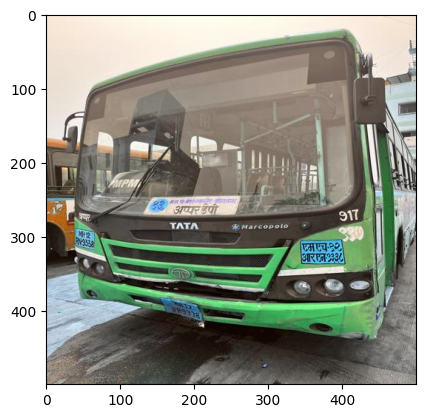

In [6]:
img_path = 'C:/Dataset/Hierarchy2/FrontBus/IMG_3650.jpg'
img = cv2.imread(img_path)

modelA = joblib.load('Trained_Models/Hierarchy1/model_dt_A_tuning')
modelA_pred = modelA.predict(featureReduction1(siftFeatures(img_path)))
modelA_proba = modelA.predict_proba(featureReduction1(siftFeatures(img_path)))

predicted_index = modelA_proba.argmax()

class_labels = ["Bus", "NotBus"]

predicted_label = class_labels[predicted_index]

print(predicted_label)
if predicted_label == 'Bus':
    engine.say("A bus has been detected")
    engine.runAndWait()
    modelA = joblib.load('Trained_Models/Hierarchy2/model_dt_A_tuning')
    modelA_pred = modelA.predict(featureReduction2(siftFeatures(img_path)))
    modelA_proba = modelA.predict_proba(featureReduction2(siftFeatures(img_path)))
    predicted_index = modelA_proba.argmax()
    class_labels = ["BackBus", "FrontBus", "InsideBus", "SideBus"]
    predicted_label = class_labels[predicted_index]
    if predicted_label == 'FrontBus':
        engine.say("The bus is approaching")
        engine.runAndWait()
        engine.say("The bus number is: ")
        engine.runAndWait()
        reader = easyocr.Reader(['en'], gpu=False)
        result = reader.readtext(img,paragraph="False")
        result_array = np.array(result)
        last_column = result_array[:, -1]
        print(last_column)
        desired_string = ''
        for text in last_column:
            if 'marcopolo' in text.lower():
                parts = text.lower().split('marcopolo')
                if len(parts) == 2:
                    desired_string = parts[0] + parts[1]
        print(desired_string)
        engine.say(desired_string)
        engine.runAndWait()
        for string in last_column:
            match = re.search(r'\d{3}', string)
            if match:
                numbers = match.group()
                print(numbers)
                engine.say(numbers)
                engine.runAndWait()

    elif predicted_label == 'InsideBus':
        engine.say("You are inside the bus")
        engine.runAndWait()
        face_cascade = cv2.CascadeClassifier('./AlgorithmParts/haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1)
        count=0
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            count=count+1
        seats=20-count
        print("Number of empty seats: " , 20 - count)
        engine.say("The total number of empty seats in the bus are: ")
        engine.runAndWait()
        engine.say(seats)
        engine.runAndWait()

    elif predicted_label == 'SideBus':
        engine.say("You are at the bus entrance side")
        engine.runAndWait()

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        threshold_value = 50
        _, binary_image = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        largest_area = 0
        largest_rectangular_contour = None
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > largest_area:
                perimeter = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
                if len(approx) == 4:
                    largest_area = area
                    largest_rectangular_contour = approx

        if largest_rectangular_contour is not None:
            x, y, w, h = cv2.boundingRect(largest_rectangular_contour)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

            center_x = x + w / 2
            center_y = y + h / 2
            image_center_x = img.shape[1] / 2
            if center_x < image_center_x - w / 2:
                res = 'Entry Door is on the left side'
            elif center_x > image_center_x + w / 2:
                res ='Entry Door is on the right side'
            else:
                res = 'Entry Door is in front'
        engine.say(res)
        engine.runAndWait()
        mask = np.zeros(img.shape[:2],np.uint8)

        bgdModel =  np.zeros((1,65),np.float64)*255
        fgdModel =  np.zeros((1,65),np.float64)*255

        rect =	(134,150,660,730)
        cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
                    cv2.GC_INIT_WITH_RECT)
        mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
        img  = img*mask2[:,:,np.newaxis]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

        horizontal_lines = []
        for line in lines:
            rho, theta = line[0]
            if theta == 0:
                horizontal_lines.append(line)

        count = 0
        for line in horizontal_lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            count+=1
        print('Total Number of Steps : ' , count+1)
        engine.say("The total number of steps to get on the bus are: ")
        engine.runAndWait()
        engine.say(count + 1)
        engine.runAndWait()
        
    elif predicted_label == 'BackBus':
        engine.say("The bus is leaving")
        engine.runAndWait()
else:
    engine.say("No bus has been detected yet")
    engine.runAndWait()
    
img_path = cv2.imread('C:/Dataset/Hierarchy2/FrontBus/IMG_3650.jpg')
plt.imshow (img_path)
plt.show

### Inside Bus

Bus
Number of empty seats:  15


<function matplotlib.pyplot.show(close=None, block=None)>

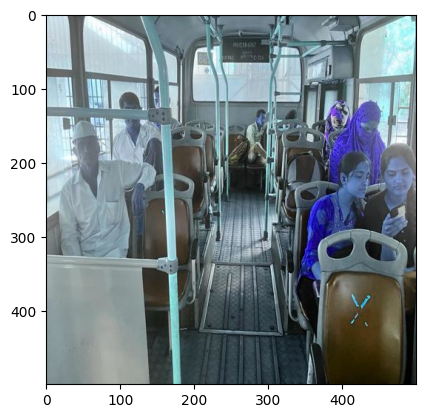

In [7]:
img_path = 'C:/Dataset/Hierarchy2/InsideBus/resized_52.jpg'
img = cv2.imread(img_path)

modelA = joblib.load('Trained_Models/Hierarchy1/model_dt_A_tuning')
modelA_pred = modelA.predict(featureReduction1(siftFeatures(img_path)))
modelA_proba = modelA.predict_proba(featureReduction1(siftFeatures(img_path)))

predicted_index = modelA_proba.argmax()

class_labels = ["Bus", "NotBus"]

predicted_label = class_labels[predicted_index]

print(predicted_label)
if predicted_label == 'Bus':
    engine.say("A bus has been detected")
    engine.runAndWait()
    modelA = joblib.load('Trained_Models/Hierarchy2/model_lgbm_A')
    modelA_pred = modelA.predict(featureReduction2(siftFeatures(img_path)))
    modelA_proba = modelA.predict_proba(featureReduction2(siftFeatures(img_path)))
    predicted_index = modelA_proba.argmax()
    class_labels = ["BackBus", "FrontBus", "InsideBus", "SideBus"]
    predicted_label = class_labels[predicted_index]
    if predicted_label == 'FrontBus':
        engine.say("The bus is approaching")
        engine.runAndWait()
        engine.say("The bus number is: ")
        engine.runAndWait()
        reader = easyocr.Reader(['en'], gpu=False)
        result = reader.readtext(img,paragraph="False")
        result_array = np.array(result)
        last_column = result_array[:, -1]
        print(last_column)
        desired_string = ''
        for text in last_column:
            if 'marcopolo' in text.lower():
                parts = text.lower().split('marcopolo')
                if len(parts) == 2:
                    desired_string = parts[0] + parts[1]
        print(desired_string)
        engine.say(desired_string)
        engine.runAndWait()
        for string in last_column:
            match = re.search(r'\d{3}', string)
            if match:
                numbers = match.group()
                print(numbers)
                engine.say(numbers)
                engine.runAndWait()

    elif predicted_label == 'InsideBus':
        engine.say("You are inside the bus")
        engine.runAndWait()
        face_cascade = cv2.CascadeClassifier('./AlgorithmParts/haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1)
        count=0
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            count=count+1
        seats=20-count
        print("Number of empty seats: " , 20 - count)
        engine.say("The total number of empty seats in the bus are: ")
        engine.runAndWait()
        engine.say(seats)
        engine.runAndWait()

    elif predicted_label == 'SideBus':
        engine.say("You are at the bus entrance side")
        engine.runAndWait()

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        threshold_value = 50
        _, binary_image = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        largest_area = 0
        largest_rectangular_contour = None
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > largest_area:
                perimeter = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
                if len(approx) == 4:
                    largest_area = area
                    largest_rectangular_contour = approx

        if largest_rectangular_contour is not None:
            x, y, w, h = cv2.boundingRect(largest_rectangular_contour)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

            center_x = x + w / 2
            center_y = y + h / 2
            image_center_x = img.shape[1] / 2
            if center_x < image_center_x - w / 2:
                res = 'Entry Door is on the left side'
            elif center_x > image_center_x + w / 2:
                res ='Entry Door is on the right side'
            else:
                res = 'Entry Door is in front'
        engine.say(res)
        engine.runAndWait()
        mask = np.zeros(img.shape[:2],np.uint8)

        bgdModel =  np.zeros((1,65),np.float64)*255
        fgdModel =  np.zeros((1,65),np.float64)*255

        rect =	(134,150,660,730)
        cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
                    cv2.GC_INIT_WITH_RECT)
        mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
        img  = img*mask2[:,:,np.newaxis]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

        horizontal_lines = []
        for line in lines:
            rho, theta = line[0]
            if theta == 0:
                horizontal_lines.append(line)

        count = 0
        for line in horizontal_lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            count+=1
        print('Total Number of Steps : ' , count+1)
        engine.say("The total number of steps to get on the bus are: ")
        engine.runAndWait()
        engine.say(count + 1)
        engine.runAndWait()
        
    elif predicted_label == 'BackBus':
        engine.say("The bus is leaving")
        engine.runAndWait()
else:
    engine.say("No bus has been detected yet")
    engine.runAndWait()
    
img_path = cv2.imread('C:/Dataset/Hierarchy2/InsideBus/resized_52.jpg')
plt.imshow (img_path)
plt.show

### Side Bus

Bus
Total Number of Steps :  3


<function matplotlib.pyplot.show(close=None, block=None)>

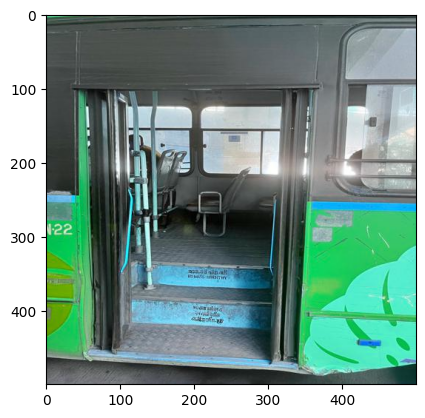

In [8]:
img_path = 'C:/Dataset/Hierarchy2/SideBus/resized_34.jpg'
img = cv2.imread(img_path)

modelA = joblib.load('Trained_Models/Hierarchy1/model_dt_A_tuning')
modelA_pred = modelA.predict(featureReduction1(siftFeatures(img_path)))
modelA_proba = modelA.predict_proba(featureReduction1(siftFeatures(img_path)))

predicted_index = modelA_proba.argmax()

class_labels = ["Bus", "NotBus"]

predicted_label = class_labels[predicted_index]

print(predicted_label)
if predicted_label == 'Bus':
    engine.say("A bus has been detected")
    engine.runAndWait()
    modelA = joblib.load('Trained_Models/Hierarchy2/model_dt_A')
    modelA_pred = modelA.predict(featureReduction2(siftFeatures(img_path)))
    modelA_proba = modelA.predict_proba(featureReduction2(siftFeatures(img_path)))
    predicted_index = modelA_proba.argmax()
    class_labels = ["BackBus", "FrontBus", "InsideBus", "SideBus"]
    predicted_label = class_labels[predicted_index]
    if predicted_label == 'FrontBus':
        engine.say("The bus is approaching")
        engine.runAndWait()
        engine.say("The bus number is: ")
        engine.runAndWait()
        reader = easyocr.Reader(['en'], gpu=False)
        result = reader.readtext(img,paragraph="False")
        result_array = np.array(result)
        last_column = result_array[:, -1]
        print(last_column)
        desired_string = ''
        for text in last_column:
            if 'marcopolo' in text.lower():
                parts = text.lower().split('marcopolo')
                if len(parts) == 2:
                    desired_string = parts[0] + parts[1]
        print(desired_string)
        engine.say(desired_string)
        engine.runAndWait()
        for string in last_column:
            match = re.search(r'\d{3}', string)
            if match:
                numbers = match.group()
                print(numbers)
                engine.say(numbers)
                engine.runAndWait()

    elif predicted_label == 'InsideBus':
        engine.say("You are inside the bus")
        engine.runAndWait()
        face_cascade = cv2.CascadeClassifier('./AlgorithmParts/haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1)
        count=0
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            count=count+1
        seats=20-count
        print("Number of empty seats: " , 20 - count)
        engine.say("The total number of empty seats in the bus are: ")
        engine.runAndWait()
        engine.say(seats)
        engine.runAndWait()

    elif predicted_label == 'SideBus':
        engine.say("You are at the bus entrance side")
        engine.runAndWait()

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        threshold_value = 50
        _, binary_image = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        largest_area = 0
        largest_rectangular_contour = None
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > largest_area:
                perimeter = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
                if len(approx) == 4:
                    largest_area = area
                    largest_rectangular_contour = approx

        if largest_rectangular_contour is not None:
            x, y, w, h = cv2.boundingRect(largest_rectangular_contour)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

            center_x = x + w / 2
            center_y = y + h / 2
            image_center_x = img.shape[1] / 2
            if center_x < image_center_x - w / 2:
                res = 'Entry Door is on the left side'
            elif center_x > image_center_x + w / 2:
                res ='Entry Door is on the right side'
            else:
                res = 'Entry Door is in front'
        engine.say(res)
        engine.runAndWait()
        mask = np.zeros(img.shape[:2],np.uint8)

        bgdModel =  np.zeros((1,65),np.float64)*255
        fgdModel =  np.zeros((1,65),np.float64)*255

        rect =	(134,150,660,730)
        cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
                    cv2.GC_INIT_WITH_RECT)
        mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
        img  = img*mask2[:,:,np.newaxis]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

        horizontal_lines = []
        for line in lines:
            rho, theta = line[0]
            if theta == 0:
                horizontal_lines.append(line)

        count = 0
        for line in horizontal_lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            count+=1
        print('Total Number of Steps : ' , count+1)
        engine.say("The total number of steps to get on the bus are: ")
        engine.runAndWait()
        engine.say(count + 1)
        engine.runAndWait()
        
    elif predicted_label == 'BackBus':
        engine.say("The bus is leaving")
        engine.runAndWait()
else:
    engine.say("No bus has been detected yet")
    engine.runAndWait()
    
img_path = cv2.imread('C:/Dataset/Hierarchy2/SideBus/resized_34.jpg')
plt.imshow (img_path)
plt.show

### Back Bus

Bus


<function matplotlib.pyplot.show(close=None, block=None)>

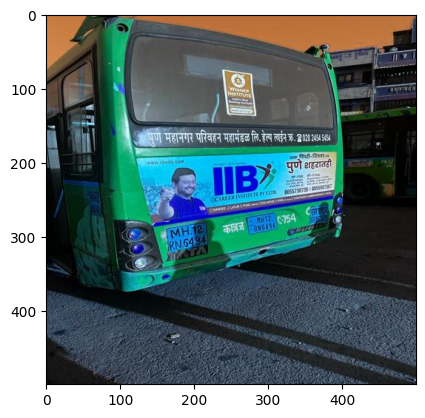

In [9]:
img_path = 'C:/Dataset/Hierarchy2/BackBus/6.jpg'
img = cv2.imread(img_path)

modelA = joblib.load('Trained_Models/Hierarchy1/model_dt_A_tuning')
modelA_pred = modelA.predict(featureReduction1(siftFeatures(img_path)))
modelA_proba = modelA.predict_proba(featureReduction1(siftFeatures(img_path)))

predicted_index = modelA_proba.argmax()

class_labels = ["Bus", "NotBus"]

predicted_label = class_labels[predicted_index]

print(predicted_label)
if predicted_label == 'Bus':
    engine.say("A bus has been detected")
    engine.runAndWait()
    modelA = joblib.load('Trained_Models/Hierarchy2/model_dt_A_tuning')
    modelA_pred = modelA.predict(featureReduction2(siftFeatures(img_path)))
    modelA_proba = modelA.predict_proba(featureReduction2(siftFeatures(img_path)))
    predicted_index = modelA_proba.argmax()
    class_labels = ["BackBus", "FrontBus", "InsideBus", "SideBus"]
    predicted_label = class_labels[predicted_index]
    if predicted_label == 'FrontBus':
        engine.say("The bus is approaching")
        engine.runAndWait()
        engine.say("The bus number is: ")
        engine.runAndWait()
        reader = easyocr.Reader(['en'], gpu=False)
        result = reader.readtext(img,paragraph="False")
        result_array = np.array(result)
        last_column = result_array[:, -1]
        print(last_column)
        desired_string = ''
        for text in last_column:
            if 'marcopolo' in text.lower():
                parts = text.lower().split('marcopolo')
                if len(parts) == 2:
                    desired_string = parts[0] + parts[1]
        print(desired_string)
        engine.say(desired_string)
        engine.runAndWait()
        for string in last_column:
            match = re.search(r'\d{3}', string)
            if match:
                numbers = match.group()
                print(numbers)
                engine.say(numbers)
                engine.runAndWait()

    elif predicted_label == 'InsideBus':
        engine.say("You are inside the bus")
        engine.runAndWait()
        face_cascade = cv2.CascadeClassifier('./AlgorithmParts/haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1)
        count=0
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            count=count+1
        seats=20-count
        print("Number of empty seats: " , 20 - count)
        engine.say("The total number of empty seats in the bus are: ")
        engine.runAndWait()
        engine.say(seats)
        engine.runAndWait()

    elif predicted_label == 'SideBus':
        engine.say("You are at the bus entrance side")
        engine.runAndWait()

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        threshold_value = 50
        _, binary_image = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        largest_area = 0
        largest_rectangular_contour = None
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > largest_area:
                perimeter = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
                if len(approx) == 4:
                    largest_area = area
                    largest_rectangular_contour = approx

        if largest_rectangular_contour is not None:
            x, y, w, h = cv2.boundingRect(largest_rectangular_contour)
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

            center_x = x + w / 2
            center_y = y + h / 2
            image_center_x = img.shape[1] / 2
            if center_x < image_center_x - w / 2:
                res = 'Entry Door is on the left side'
            elif center_x > image_center_x + w / 2:
                res ='Entry Door is on the right side'
            else:
                res = 'Entry Door is in front'
        engine.say(res)
        engine.runAndWait()
        mask = np.zeros(img.shape[:2],np.uint8)

        bgdModel =  np.zeros((1,65),np.float64)*255
        fgdModel =  np.zeros((1,65),np.float64)*255

        rect =	(134,150,660,730)
        cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
                    cv2.GC_INIT_WITH_RECT)
        mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
        img  = img*mask2[:,:,np.newaxis]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

        horizontal_lines = []
        for line in lines:
            rho, theta = line[0]
            if theta == 0:
                horizontal_lines.append(line)

        count = 0
        for line in horizontal_lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            count+=1
        print('Total Number of Steps : ' , count+1)
        engine.say("The total number of steps to get on the bus are: ")
        engine.runAndWait()
        engine.say(count + 1)
        engine.runAndWait()
        
    elif predicted_label == 'BackBus':
        engine.say("The bus is leaving")
        engine.runAndWait()
else:
    engine.say("No bus has been detected yet")
    engine.runAndWait()
    
img_path = cv2.imread('C:/Dataset/Hierarchy2/BackBus/6.jpg')
plt.imshow (img_path)
plt.show

### Not Bus

NotBus


<function matplotlib.pyplot.show(close=None, block=None)>

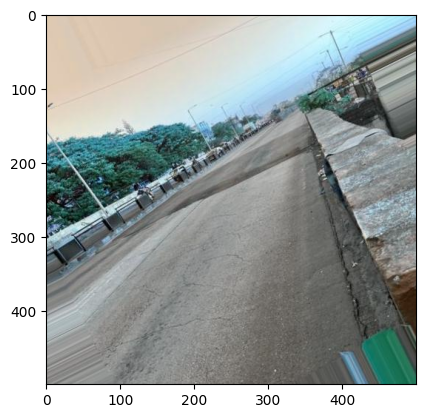

In [10]:
img_path = 'C:/Dataset/Hierarchy1/NotBus/aug_0_6324.jpg'
img = cv2.imread(img_path)

modelA = joblib.load('Trained_Models/Hierarchy1/model_RF_A')
modelA_pred = modelA.predict(featureReduction1(siftFeatures(img_path)))
modelA_proba = modelA.predict_proba(featureReduction1(siftFeatures(img_path)))

predicted_index = modelA_proba.argmax()

class_labels = ["Bus", "NotBus"]

predicted_label = class_labels[predicted_index]

print(predicted_label)
if predicted_label == 'Bus':
    engine.say("A bus has been detected")
    engine.runAndWait()
    modelA = joblib.load('Trained_Models/Hierarchy2/model_dt_A_tuning')
    modelA_pred = modelA.predict(featureReduction2(siftFeatures(img_path)))
    modelA_proba = modelA.predict_proba(featureReduction2(siftFeatures(img_path)))
    predicted_index = modelA_proba.argmax()
    class_labels = ["BackBus", "FrontBus", "InsideBus", "SideBus"]
    predicted_label = class_labels[predicted_index]
    if predicted_label == 'FrontBus':
        engine.say("The bus is approaching")
        engine.runAndWait()
        engine.say("The bus number is: ")
        engine.runAndWait()
        reader = easyocr.Reader(['en'], gpu=False)
        result = reader.readtext(img,paragraph="False")
        result_array = np.array(result)
        last_column = result_array[:, -1]
        print(last_column)
        desired_string = ''
        for text in last_column:
            if 'marcopolo' in text.lower():
                parts = text.lower().split('marcopolo')
                if len(parts) == 2:
                    desired_string = parts[0] + parts[1]
        print(desired_string)
        engine.say(desired_string)
        engine.runAndWait()
        for string in last_column:
            match = re.search(r'\d{3}', string)
            if match:
                numbers = match.group()
                print(numbers)
                engine.say(numbers)
                engine.runAndWait()

    elif predicted_label == 'InsideBus':
        engine.say("You are inside the bus")
        engine.runAndWait()
        face_cascade = cv2.CascadeClassifier('./AlgorithmParts/haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=1)
        count=0
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            count=count+1
        seats=20-count
        print("Number of empty seats: " , 20 - count)
        engine.say("The total number of empty seats in the bus are: ")
        engine.runAndWait()
        engine.say(seats)
        engine.runAndWait()

    elif predicted_label == 'SideBus':
        engine.say("You are at the bus entrance side")
        engine.runAndWait()

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        threshold_value = 50
        _, binary_image = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        largest_area = 0
        largest_rectangular_contour = None
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > largest_area:
                perimeter = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.04 * perimeter, True)
                if len(approx) == 4:
                    largest_area = area
                    largest_rectangular_contour = approx

        if largest_rectangular_contour is not None:
            x, y, w, h = cv2.boundingRect(largest_rectangular_contour)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

            center_x = x + w / 2
            center_y = y + h / 2
            image_center_x = image.shape[1] / 2
            if center_x < image_center_x - w / 2:
                res = 'Entry Door is on the left side'
            elif center_x > image_center_x + w / 2:
                res ='Entry Door is on the right side'
            else:
                res = 'Entry Door is in front'
        engine.say(res)
        engine.runAndWait()
        mask = np.zeros(img.shape[:2],np.uint8)

        bgdModel =  np.zeros((1,65),np.float64)*255
        fgdModel =  np.zeros((1,65),np.float64)*255

        rect =	(134,150,660,730)
        cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,
                    cv2.GC_INIT_WITH_RECT)
        mask2  =  np.where((mask==2)|(mask==0),0,1).astype('uint8')
        img  = img*mask2[:,:,np.newaxis]

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        edges = cv2.Canny(gray, 50, 150, apertureSize=3)

        lines = cv2.HoughLines(edges, 1, np.pi/180, 100)

        horizontal_lines = []
        for line in lines:
            rho, theta = line[0]
            if theta == 0:
                horizontal_lines.append(line)

        count = 0
        for line in horizontal_lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            count+=1
        print('Total Number of Steps : ' , count+1)
        engine.say("The total number of steps to get on the bus are: ")
        engine.runAndWait()
        engine.say(count + 1)
        engine.runAndWait()
        
    elif predicted_label == 'BackBus':
        engine.say("The bus is leaving")
        engine.runAndWait()
else:
    engine.say("No bus has been detected yet")
    engine.runAndWait()
    
img_path = cv2.imread('C:/Dataset/Hierarchy1/NotBus/aug_0_6324.jpg')
plt.imshow (img_path)
plt.show